# Programming Exercise 6:
# Support Vector Machines

## Introduction

In this exercise, you will be using support vector machines (SVMs) to build a spam classifier. Before starting on the programming exercise, we strongly recommend watching the video lectures and completing the review questions for the associated topics.

All the information you need for solving this assignment is in this notebook, and all the code you will be implementing will take place within this notebook. The assignment can be promptly submitted to the coursera grader directly from this notebook (code and instructions are included below).

Before we begin with the exercises, we need to import all libraries required for this programming exercise. Throughout the course, we will be using [`numpy`](http://www.numpy.org/) for all arrays and matrix operations, [`matplotlib`](https://matplotlib.org/) for plotting, and [`scipy`](https://docs.scipy.org/doc/scipy/reference/) for scientific and numerical computation functions and tools.

In [1]:
import re
import numpy as np
from scipy.io import loadmat
from scipy import optimize
import matplotlib.pyplot as plt

## 1 Support Vector Machines

In the first half of this exercise, you will be using support vector machines (SVMs) with various example 2D datasets. Experimenting with these datasets will help you gain an intuition of how SVMs work and how to use a Gaussian kernel with SVMs. In the next half of the exercise, you will be using support
vector machines to build a spam classifier.

### 1.1 Example Dataset 1

We will begin by with a 2D example dataset which can be separated by a linear boundary. The following cell plots the training data, which should look like this:

![Dataset 1 training data](Figures/dataset1.png)

In this dataset, the positions of the positive examples (indicated with `x`) and the negative examples (indicated with `o`) suggest a natural separation indicated by the gap. However, notice that there is an outlier positive example `x` on the far left at about (0.1, 4.1). As part of this exercise, you will also see how this outlier affects the SVM decision boundary.

In [2]:
def plot_data(X, y, grid=False):
    """
    Plots the data points X and y into a new figure. Uses `+` for positive examples, and `o` for
    negative examples. `X` is assumed to be a Mx2 matrix

    Parameters
    ----------
    X : numpy ndarray
        X is assumed to be a Mx2 matrix.

    y : numpy ndarray
        The data labels.

    grid : bool (Optional)
        Specify whether or not to show the grid in the plot. It is False by default.
    """
    # Find Indices of Positive and Negative Examples
    pos = y == 1
    neg = y == 0

    # Plot Examples
    plt.plot(X[pos, 0], X[pos, 1], 'X', mew=1, ms=10, mec='k')
    plt.plot(X[neg, 0], X[neg, 1], 'o', mew=1, mfc='y', ms=10, mec='k')
    plt.grid(grid)

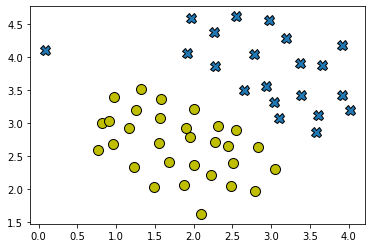

In [3]:
# Load from ex6data1
# You will have X, y as keys in the dict data
data = loadmat("Data/ex6data1.mat")
X, y = data['X'], data['y'][:, 0]

# Plot training data
plot_data(X, y)

In this part of the exercise, you will try using different values of the $C$ parameter with SVMs. Informally, the $C$ parameter is a positive value that controls the penalty for misclassified training examples. A large $C$ parameter tells the SVM to try to classify all the examples correctly. $C$ plays a role similar to $1/\lambda$, where $\lambda$ is the regularization parameter that we were using previously for logistic regression.


The following cell will run the SVM training (with $C=1$) using SVM software that we have included with the starter code (function `svmTrain` within the `utils` module of this exercise). When $C=1$, you should find that the SVM puts the decision boundary in the gap between the two datasets and *misclassifies* the data point on the far left, as shown in the figure (left) below.

<table style="text-align:center">
    <tr>
        <th colspan="2" style="text-align:center">SVM Decision boundary for example dataset 1 </th>
    </tr>
    <tr>
        <td style="text-align:center">C=1<img src="Figures/svm_c1.png"/></td>
        <td style="text-align:center">C=100<img src="Figures/svm_c100.png"/></td>
    </tr>
</table>

**Implementation Note:** Most SVM software packages automatically add the extra feature $x_0$ = 1 for you and automatically take care of learning the intercept term $\theta_0$. So when passing your training data to the SVM software, there is no need to add this extra feature $x_0 = 1$ yourself. In particular, in python your code should be working with training examples $x \in \mathcal{R}^n$ (rather than $x \in \mathcal{R}^{n+1}$); for example, in the first example dataset $x \in \mathcal{R}^2$.

Your task is to try different values of $C$ on this dataset. Specifically, you should change the value of $C$ in the next cell to $C = 100$ and run the SVM training again. When $C = 100$, you should find that the SVM now classifies every single example correctly, but has a decision boundary that does not
appear to be a natural fit for the data.

In [4]:
def linear_kernel(x1, x2):
    """
    Returns a linear kernel between x1 and x2.

    Parameters
    ----------
    x1 : numpy ndarray
        A 1-D vector.

    x2 : numpy ndarray
        A 1-D vector of same size as x1.

    Returns
    -------
    : float
        The scalar amplitude.
    """
    return np.dot(x1, x2)

In [5]:
def svm_train(X, Y, C, kernelFunction, tol=1e-3, max_passes=5, args=()):
    """
    Trains an SVM classifier using a  simplified version of the SMO algorithm.

    Parameters
    ---------
    X : numpy ndarray
        (m x n) Matrix of training examples. Each row is a training example, and the
        jth column holds the jth feature.

    Y : numpy ndarray
        (m, ) A vector (1-D numpy array) containing 1 for positive examples and 0 for negative examples.

    C : float
        The standard SVM regularization parameter.

    kernelFunction : func
        A function handle which computes the kernel. The function should accept two vectors as
        inputs, and returns a scalar as output.

    tol : float, optional
        Tolerance value used for determining equality of floating point numbers.

    max_passes : int, optional
        Controls the number of iterations over the dataset (without changes to alpha)
        before the algorithm quits.

    args : tuple
        Extra arguments required for the kernel function, such as the sigma parameter for a
        Gaussian kernel.

    Returns
    -------
    model :
        The trained SVM model.

    Notes
    -----
    This is a simplified version of the SMO algorithm for training SVMs. In practice, if
    you want to train an SVM classifier, we recommend using an optimized package such as:

    - LIBSVM   (http://www.csie.ntu.edu.tw/~cjlin/libsvm/)
    - SVMLight (http://svmlight.joachims.org/)
    - scikit-learn (http://scikit-learn.org/stable/modules/svm.html) which contains python wrappers
    for the LIBSVM library.
    """
    # make sure data is signed int
    Y = Y.astype(int)
    # Dataset size parameters
    m, n = X.shape

    passes = 0
    E = np.zeros(m)
    alphas = np.zeros(m)
    b = 0

    # Map 0 to -1
    Y[Y == 0] = -1

    # Pre-compute the Kernel Matrix since our dataset is small
    # (in practice, optimized SVM packages that handle large datasets
    # gracefully will **not** do this)

    # We have implemented the optimized vectorized version of the Kernels here so
    # that the SVM training will run faster
    if kernelFunction.__name__ == 'linear_kernel':
        # Vectorized computation for the linear kernel
        # This is equivalent to computing the kernel on every pair of examples
        K = np.dot(X, X.T)
    elif kernelFunction.__name__ == 'gaussian_kernel':
        # vectorized RBF Kernel
        # This is equivalent to computing the kernel on every pair of examples
        X2 = np.sum(X**2, axis=1)
        K = X2 + X2[:, None] - 2 * np.dot(X, X.T)

        if len(args) > 0:
            K /= 2*args[0]**2

        K = np.exp(-K)
    else:
        K = np.zeros((m, m))
        for i in range(m):
            for j in range(i, m):
                K[i, j] = kernelFunction(X[i, :], X[j, :])
                K[j, i] = K[i, j]

    while passes < max_passes:
        num_changed_alphas = 0
        for i in range(m):
            E[i] = b + np.sum(alphas * Y * K[:, i]) - Y[i]

            if (Y[i]*E[i] < -tol and alphas[i] < C) or (Y[i]*E[i] > tol and alphas[i] > 0):
                # select the alpha_j randomly
                j = np.random.choice(list(range(i)) + list(range(i+1, m)), size=1)[0]

                E[j] = b + np.sum(alphas * Y * K[:, j]) - Y[j]

                alpha_i_old = alphas[i]
                alpha_j_old = alphas[j]

                if Y[i] == Y[j]:
                    L = max(0, alphas[j] + alphas[i] - C)
                    H = min(C, alphas[j] + alphas[i])
                else:
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])

                if L == H:
                    continue

                eta = 2 * K[i, j] - K[i, i] - K[j, j]

                # objective function positive definite, there will be a minimum along the direction
                # of linear equality constrain, and eta will be greater than zero
                # we are actually computing -eta here (so we skip of eta >= 0)
                if eta >= 0:
                    continue

                alphas[j] -= Y[j] * (E[i] - E[j])/eta
                alphas[j] = max(L, min(H, alphas[j]))

                if abs(alphas[j] - alpha_j_old) < tol:
                    alphas[j] = alpha_j_old
                    continue
                alphas[i] += Y[i]*Y[j]*(alpha_j_old - alphas[j])

                b1 = b - E[i] - Y[i]*(alphas[i] - alpha_i_old) * K[i, j] \
                     - Y[j] * (alphas[j] - alpha_j_old) * K[i, j]

                b2 = b - E[j] - Y[i]*(alphas[i] - alpha_i_old) * K[i, j] \
                     - Y[j] * (alphas[j] - alpha_j_old) * K[j, j]

                if 0 < alphas[i] < C:
                    b = b1
                elif 0 < alphas[j] < C:
                    b = b2
                else:
                    b = (b1 + b2)/2

                num_changed_alphas += 1
        if num_changed_alphas == 0:
            passes += 1
        else:
            passes = 0

    idx = alphas > 0
    model = {'X': X[idx, :],
             'y': Y[idx],
             'kernelFunction': kernelFunction,
             'b': b,
             'args': args,
             'alphas': alphas[idx],
             'w': np.dot(alphas * Y, X)}
    return model

In [6]:
def svm_predict(model, X):
    """
    Returns a vector of predictions using a trained SVM model.

    Parameters
    ----------
    model : dict
        The parameters of the trained svm model, as returned by the function svmTrain

    X : array_like
        A (m x n) matrix where each example is a row.

    Returns
    -------
    pred : array_like
        A (m,) sized vector of predictions {0, 1} values.
    """
    # check if we are getting a vector. If so, then assume we only need to do predictions
    # for a single example
    if X.ndim == 1:
        X = X[np.newaxis, :]

    m = X.shape[0]
    p = np.zeros(m)
    pred = np.zeros(m)

    if model['kernelFunction'].__name__ == 'linear_kernel':
        # we can use the weights and bias directly if working with the linear kernel
        p = np.dot(X, model['w']) + model['b']
    elif model['kernelFunction'].__name__ == 'gaussian_kernel':
        # vectorized RBF Kernel
        # This is equivalent to computing the kernel on every pair of examples
        X1 = np.sum(X**2, 1)
        X2 = np.sum(model['X']**2, 1)
        K = X2 + X1[:, None] - 2 * np.dot(X, model['X'].T)

        if len(model['args']) > 0:
            K /= 2*model['args'][0]**2

        K = np.exp(-K)
        p = np.dot(K, model['alphas']*model['y']) + model['b']
    else:
        # other non-linear kernel
        for i in range(m):
            predictions = 0
            for j in range(model['X'].shape[0]):
                predictions += model['alphas'][j] * model['y'][j] \
                               * model['kernelFunction'](X[i, :], model['X'][j, :])
            p[i] = predictions

    pred[p >= 0] = 1
    return pred

In [7]:
def visualize_boundary_linear(X, y, model):
    """
    Plots a linear decision boundary learned by the SVM.

    Parameters
    ----------
    X : array_like
        (m x 2) The training data with two features (to plot in a 2-D plane).

    y : array_like
        (m, ) The data labels.

    model : dict
        Dictionary of model variables learned by SVM.
    """
    w, b = model['w'], model['b']
    xp = np.linspace(min(X[:, 0]), max(X[:, 0]), 100)
    yp = -(w[0] * xp + b)/w[1]

    plot_data(X, y)
    plt.plot(xp, yp, '-b')

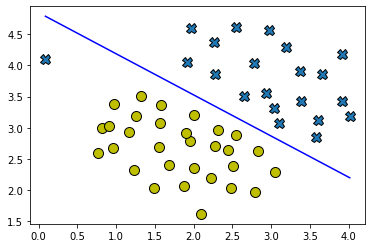

In [8]:
# You should try to change the C value below and see how the decision
# boundary varies (e.g., try C = 1000)
C = 1

model = svm_train(X, y, C, linear_kernel, 1e-3, 20)
visualize_boundary_linear(X, y, model)

### 1.2 SVM with Gaussian Kernels

In this part of the exercise, you will be using SVMs to do non-linear classification. In particular, you will be using SVMs with Gaussian kernels on datasets that are not linearly separable.

#### 1.2.1 Gaussian Kernel

To find non-linear decision boundaries with the SVM, we need to first implement a Gaussian kernel. You can think of the Gaussian kernel as a similarity function that measures the “distance” between a pair of examples,
($x^{(i)}$, $x^{(j)}$). The Gaussian kernel is also parameterized by a bandwidth parameter, $\sigma$, which determines how fast the similarity metric decreases (to 0) as the examples are further apart.
You should now complete the code in `gaussianKernel` to compute the Gaussian kernel between two examples, ($x^{(i)}$, $x^{(j)}$). The Gaussian kernel function is defined as:

$$ K_{\text{gaussian}} \left( x^{(i)}, x^{(j)} \right) = \exp \left( - \frac{\left\lvert\left\lvert x^{(i)} - x^{(j)}\right\lvert\right\lvert^2}{2\sigma^2} \right) = \exp \left( -\frac{\sum_{k=1}^n \left( x_k^{(i)} - x_k^{(j)}\right)^2}{2\sigma^2} \right)$$

In [9]:
def gaussian_kernel(x1, x2, sigma):
    """
    Computes the radial basis function
    Returns a radial basis function kernel between x1 and x2.
    
    Parameters
    ----------
    x1 :  numpy ndarray
        A vector of size (n, ), representing the first datapoint.
    
    x2 : numpy ndarray
        A vector of size (n, ), representing the second datapoint.
    
    sigma : float
        The bandwidth parameter for the Gaussian kernel.

    Returns
    -------
    sim : float
        The computed RBF between the two provided data points.
    
    Instructions
    ------------
    Fill in this function to return the similarity between `x1` and `x2`
    computed using a Gaussian kernel with bandwidth `sigma`.
    """
    sim = 0

    sim = np.exp(-np.sum((x1 - x2) ** 2) / (2 * (sigma ** 2)))

    return sim

Once you have completed the function `gaussian_kernel` the following cell will test your kernel function on two provided examples and you should expect to see a value of 0.324652.

In [10]:
x1 = np.array([1, 2, 1])
x2 = np.array([0, 4, -1])
sigma = 2

sim = gaussian_kernel(x1, x2, sigma)

print('Gaussian Kernel between x1 = [1, 2, 1], x2 = [0, 4, -1], sigma = %0.2f:'
      '\n\t%f\n(for sigma = 2, this value should be about 0.324652)\n' % (sigma, sim))

Gaussian Kernel between x1 = [1, 2, 1], x2 = [0, 4, -1], sigma = 2.00:
	0.324652
(for sigma = 2, this value should be about 0.324652)



### 1.2.2 Example Dataset 2

The next part in this notebook will load and plot dataset 2, as shown in the figure below. 

![Dataset 2](Figures/dataset2.png)

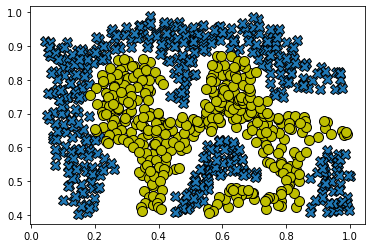

In [11]:
# Load from ex6data2
# You will have X, y as keys in the dict data
data = loadmat("Data/ex6data2.mat")
X, y = data['X'], data['y'][:, 0]

# Plot training data
plot_data(X, y)

From the figure, you can obserse that there is no linear decision boundary that separates the positive and negative examples for this dataset. However, by using the Gaussian kernel with the SVM, you will be able to learn a non-linear decision boundary that can perform reasonably well for the dataset. If you have correctly implemented the Gaussian kernel function, the following cell will proceed to train the SVM with the Gaussian kernel on this dataset.

You should get a decision boundary as shown in the figure below, as computed by the SVM with a Gaussian kernel. The decision boundary is able to separate most of the positive and negative examples correctly and follows the contours of the dataset well.

![Dataset 2 decision boundary](Figures/svm_dataset2.png)

In [12]:
def visualize_boundary(X, y, model):
    """
    Plots a non-linear decision boundary learned by the SVM and overlays the data on it.

    Parameters
    ----------
    X : array_like
        (m x 2) The training data with two features (to plot in a 2-D plane).

    y : array_like
        (m, ) The data labels.

    model : dict
        Dictionary of model variables learned by SVM.
    """
    plot_data(X, y)

    # make classification predictions over a grid of values
    x1plot = np.linspace(min(X[:, 0]), max(X[:, 0]), 100)
    x2plot = np.linspace(min(X[:, 1]), max(X[:, 1]), 100)
    X1, X2 = np.meshgrid(x1plot, x2plot)

    vals = np.zeros(X1.shape)
    for i in range(X1.shape[1]):
        this_X = np.stack((X1[:, i], X2[:, i]), axis=1)
        vals[:, i] = svm_predict(model, this_X)

    plt.contour(X1, X2, vals, colors='y', linewidths=2)
    plt.pcolormesh(X1, X2, vals, cmap='YlGnBu', alpha=0.25, edgecolors='None', lw=0)
    plt.grid(False)

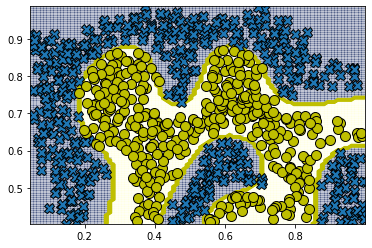

In [13]:
# SVM Parameters
C = 1
sigma = 0.1

model= svm_train(X, y, C, gaussian_kernel, args=(sigma,))
visualize_boundary(X, y, model)

<a id="section2"></a>
#### 1.2.3 Example Dataset 3

In this part of the exercise, you will gain more practical skills on how to use a SVM with a Gaussian kernel. The next cell will load and display a third dataset, which should look like the figure below.

![Dataset 3](Figures/dataset3.png)

You will be using the SVM with the Gaussian kernel with this dataset. In the provided dataset, `ex6data3.mat`, you are given the variables `X`, `y`, `Xval`, `yval`. 

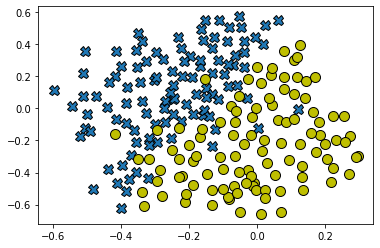

In [14]:
# Load from ex6data3
# You will have X, y, Xval, yval as keys in the dict data
data = loadmat("Data/ex6data3.mat")
X, y, Xval, yval = data['X'], data['y'][:, 0], data['Xval'], data['yval'][:, 0]

# Plot training data
plot_data(X, y)

Your task is to use the cross validation set `Xval`, `yval` to determine the best $C$ and $\sigma$ parameter to use. You should write any additional code necessary to help you search over the parameters $C$ and $\sigma$. For both $C$ and $\sigma$, we suggest trying values in multiplicative steps (e.g., 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30).
Note that you should try all possible pairs of values for $C$ and $\sigma$ (e.g., $C = 0.3$ and $\sigma = 0.1$). For example, if you try each of the 8 values listed above for $C$ and for $\sigma^2$, you would end up training and evaluating (on the cross validation set) a total of $8^2 = 64$ different models. After you have determined the best $C$ and $\sigma$ parameters to use, you should modify the code in `dataset3Params`, filling in the best parameters you found. For our best parameters, the SVM returned a decision boundary shown in the figure below. 

![](Figures/svm_dataset3_best.png)

<div class="alert alert-block alert-warning">
**Implementation Tip:** When implementing cross validation to select the best $C$ and $\sigma$ parameter to use, you need to evaluate the error on the cross validation set. Recall that for classification, the error is defined as the fraction of the cross validation examples that were classified incorrectly. In `numpy`, you can compute this error using `np.mean(predictions != yval)`, where `predictions` is a vector containing all the predictions from the SVM, and `yval` are the true labels from the cross validation set. You can use the `utils.svmPredict` function to generate the predictions for the cross validation set.
</div>
<a id="dataset3Params"></a>

In [40]:
def dataset3Params(X, y, Xval, yval):
    """
    Returns your choice of C and sigma for Part 3 of the exercise 
    where you select the optimal (C, sigma) learning parameters to use for SVM
    with RBF kernel.
    
    Parameters
    ----------
    X : array_like
        (m x n) matrix of training data where m is number of training examples, and 
        n is the number of features.
    
    y : array_like
        (m, ) vector of labels for ther training data.
    
    Xval : array_like
        (mv x n) matrix of validation data where mv is the number of validation examples
        and n is the number of features
    
    yval : array_like
        (mv, ) vector of labels for the validation data.
    
    Returns
    -------
    C, sigma : float, float
        The best performing values for the regularization parameter C and 
        RBF parameter sigma.
    
    Instructions
    ------------
    Fill in this function to return the optimal C and sigma learning 
    parameters found using the cross validation set.
    You can use `svmPredict` to predict the labels on the cross
    validation set. For example, 
    
        predictions = svmPredict(model, Xval)

    will return the predictions on the cross validation set.
    
    Note
    ----
    You can compute the prediction error using 
    
        np.mean(predictions != yval)
    """
    # You need to return the following variables correctly.
    C = 1
    sigma = 0.3
    

    C_array = np.array([0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30])
    sigma_array = np.array([0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30])

    my_array = np.zeros([C_array.size, sigma_array.size])
    err_array= np.zeros([8, 8])
    for i in np.arange(C_array.size):
        for j in np.arange(sigma_array.size):
            model= svm_train(X, y, C_array[i], gaussian_kernel, args=(sigma_array[j],))
            predictions = svm_predict(model, Xval)
            pred_error = np.mean(predictions != yval)
            
            err_array[i, j] = pred_error
        
    ind = np.unravel_index(np.argmin(err_array, axis = None), err_array.shape)
    C = C_array[ind[0]]
    sigma = sigma_array[ind[1]]

    return C, sigma

The provided code in the next cell trains the SVM classifier using the training set $(X, y)$ using parameters loaded from `dataset3_params`. Note that this might take a few minutes to execute.

0.3 0.1


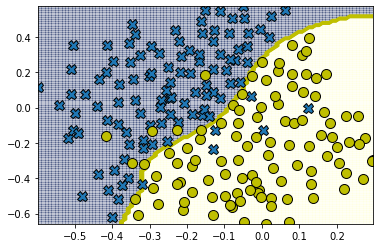

In [41]:
# Try different SVM Parameters here
C, sigma = dataset3_params(X, y, Xval, yval)

# Train the SVM
# model = utils.svmTrain(X, y, C, lambda x1, x2: gaussianKernel(x1, x2, sigma))
model = svm_train(X, y, C, gaussian_kernel, args=(sigma,))
visualize_boundary(X, y, model)
print(C, sigma)